In [1]:
import os
import re

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from keras.layers import SpatialDropout1D, Conv1D, MaxPooling1D
from gensim.models import Word2Vec
from keras.utils import np_utils
from keras.preprocessing import sequence
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
import seaborn as sns
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn import metrics

import config


Using TensorFlow backend.
C:\My_programs\Miniconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
w2v_path = os.path.join("word_embedding", "ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz")
hh_data_path = os.path.join("headHunter_data", "hh_dataset.csv")

In [3]:
dataset_hh = pd.read_csv(hh_data_path, sep="\t")
dataset_hh = dataset_hh.loc[dataset_hh["lang_text"] != "english"]
#dataset_hh.drop(dataset_hh.index[dataset_hh["lang_text"] == "english"], inplace=True)
dataset_hh.reset_index(drop=True, inplace=True)

In [4]:
dataset_hh.head()

,id,lang_title,requirement,requirement_lemmas,requirement_lemmas_tags,requirement_norm,requirement_tokens,responsibility,responsibility_lemmas,responsibility_lemmas_tags,...,title_tokens,url,lang_text,profarea_names,specializations,text,text_lemmas,text_lemmas_tags,text_normalized,text_tokens
0,29103667,russian,Высшее (желательно техническое) образование. П...,высший желательный технический образование lot...,высший_ADJ желательный_ADJ технический_ADJ обр...,высш желательн техническ образован lotus хорош...,высшее желательно техническое образование lotu...,Ежедневное планирование работы завода (молочно...,ежедневный планирование работа завод молочный ...,ежедневный_ADJ планирование_NOUN работа_NOUN з...,...,специаидать_NOUN планирование_NOUN производств...,https://api.hh.ru/vacancies/29103667?host=hh.ua,russian,"['Производство', 'Закупки']","['Пищевая промышленность', 'Управление закупка...",<p><strong>Международная компания – крупнейший...,международный компания крупнейший производител...,международный_ADJ компания_NOUN крупнейший_ADJ...,международн компан крупн производител свеж мол...,международный_ADJ компания_NOUN крупнейший_ADJ...
1,29103666,russian,Умение работать в коллективе. Образование не н...,умение работать коллектив образование ниже тех...,умение_NOUN работать_VERB коллектив_NOUN образ...,умен работа коллектив образован ниж техническ ...,умение работать коллективе образование ниже те...,Техническая подготовка выполнения сварочных ра...,технический подготовка выполнение сварочный ра...,технический_ADJ подготовка_NOUN выполнение_NOU...,...,главный_ADJ сварщик_NOUN,https://api.hh.ru/vacancies/29103666?host=hh.ua,russian,['Рабочий персонал'],['Сварщик'],<strong>Обязанности:</strong> <ul> <li><em>Тех...,обязанность технический подготовка выполнение ...,обязанность_NOUN технический_ADJ подготовка_NO...,обязан техническ подготовк выполнен сварочн ра...,обязанность_NOUN технический_ADJ подготовка_NO...
2,29103664,russian,Профильное высшее образование (Художественное/...,профильный высший образование креативность нес...,профильный_ADJ высший_ADJ образование_NOUN кре...,профильн высш образован креативн нестандартн м...,профильное высшее образование креативность нес...,Дизайн и верстка еженедельного акционного букл...,дизайн верстка еженедельный акциоть буклет раз...,дизайн_NOUN верстка_NOUN еженедельный_ADJ акци...,...,дизайнер_NOUN,https://api.hh.ru/vacancies/29103664?host=hh.ua,russian,"['Искусство, развлечения, масс-медиа', 'Маркет...","['Дизайн, графика, живопись', 'Дизайнер']",<p><strong>Сеть гипермаркетов ProStore приглаш...,сеть гипермаркет prostore приглашать постоянны...,сеть_NOUN гипермаркет_NOUN prostore_X приглаша...,сет гипермаркет prostor приглаша постоя работ ...,сеть_NOUN гипермаркет_NOUN prostore_X приглаша...
3,29103661,russian,1. Высшее образование ( в приоритете: менеджме...,высший образование приоритет менеджмент маркет...,высший_ADJ образование_NOUN приоритет_VERB мен...,высш образован приоритет менеджмент маркетинг ...,высшее образование приоритете менеджмент марке...,Наша студия помогает компаниям повышать продаж...,наш студия помогать компания повышать продажа ...,наш_DET студия_NOUN помогать_VERB компания_NOU...,...,руководитель_NOUN отдел_NOUN продажа_NOUN,https://api.hh.ru/vacancies/29103661?host=hh.ua,russian,"['Продажи', 'Продажи', 'Высший менеджмент']","['Услуги для бизнеса', 'Управление продажами',...",<p>Наша студия помогает компаниям повышать про...,наш студия помогать компания повышать продажа ...,наш_DET студия_NOUN помогать_VERB компания_NOU...,наш студ помога компан повыша продаж помощ про...,наш_DET студия_NOUN помогать_VERB компания_NOU...
4,29103660,russian,Требования: Опыт работы по специальности обяза...,требование опыт работа специальность обязатель...,требование_NOUN опыт_NOUN работа_NOUN специаль...,требован оп работ специальн обязател желательн...,требования опыт работы специальности обязателе...,Обязанности: Заточка и доводка режущего инстру...,обязанность заточка доводка рез

In [5]:
dataset_hh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 26 columns):
id                            3588 non-null int64
lang_title                    3588 non-null object
requirement                   3472 non-null object
requirement_lemmas            3472 non-null object
requirement_lemmas_tags       3472 non-null object
requirement_norm              3472 non-null object
requirement_tokens            3472 non-null object
responsibility                3409 non-null object
responsibility_lemmas         3409 non-null object
responsibility_lemmas_tags    3409 non-null object
responsibility_norm           3409 non-null object
responsibility_tokens         3409 non-null object
title                         3588 non-null object
title_lemmas                  3270 non-null object
title_lemmas_tags             3270 non-null object
title_normalized              3270 non-null object
title_tokens                  3270 non-null object
url                        

### Prapare data to rnn

In [6]:
vectorizer = KeyedVectors.load_word2vec_format(w2v_path, binary=False)


In [7]:
labels = []
for i, row in dataset_hh.iterrows():
    specs = row["profarea_names"].lower()
    specs = specs.split("', ") 
    for spec in specs: 
        spec = re.sub('[\[\'\]]', '', spec)
        labels.append(spec.strip())

labels = list(set(labels))

In [8]:
print("Labels number:", len(labels))
print("Labels:", labels)

Labels number: 28
Labels: ['искусство, развлечения, масс-медиа', 'инсталляция и сервис', 'юристы', 'туризм, гостиницы, рестораны', 'маркетинг, реклама, pr', 'домашний персонал', 'бухгалтерия, управленческий учет, финансы предприятия', 'спортивные клубы, фитнес, салоны красоты', 'административный персонал', 'управление персоналом, тренинги', 'безопасность', 'наука, образование', 'банки, инвестиции, лизинг', 'консультирование', 'информационные технологии, интернет, телеком', 'страхование', 'рабочий персонал', 'закупки', 'начало карьеры, студенты', 'высший менеджмент', 'добыча сырья', 'государственная служба, некоммерческие организации', 'автомобильный бизнес', 'производство', 'продажи', 'медицина, фармацевтика', 'строительство, недвижимость', 'транспорт, логистика']


In [9]:
def vectorize_text(text, vectorizer, max_len):
    """
    :param str text: normalized text
    :param Word2Vec vectorizer:
    :param int max_len:
    :return np.array text_vect: of shape like (1, max_len, 100)
    """
    text_vect = []
    words = text.split(" ")
    for word in words:
        try:
            word_vect = vectorizer.word_vec(word)
            text_vect.append(word_vect)
        except KeyError:
            None
      
    np.array(text_vect)
    text_vect = np.reshape(text_vect, (1, -1, 100))
    text_vect = sequence.pad_sequences(text_vect, maxlen=max_len, dtype='float')
            
    return text_vect
    

In [10]:

n_classes = len(labels)
n_examples = len(dataset_hh)
X = []
Y = np.zeros((n_examples, n_classes))
for i, row in dataset_hh.iterrows():
    X.append([])
    words = row["text_lemmas_tags"].split(" ")
    for word in words:
        try:
            word_vec = vectorizer.word_vec(word)
            X[i].append(word_vec)
        except KeyError:
            None
    
    specs = row["profarea_names"].lower() 
    specs = specs.split("', ") 
    for spec in specs: 
        spec = re.sub('[\[\'\]]', '', spec)
        pos = labels.index(spec.strip())
        Y[i][pos] = 1
        
assert(len(X) == len(Y))


In [11]:
max_len = max([len(i) for i in X])
print("Max len =", max_len)

Max len = 689


In [12]:
max_len = 300
print("Max len edited=", max_len)

Max len edited= 300


In [13]:
X = sequence.pad_sequences(X, maxlen=max_len, dtype='float')
X = np.array(X)


In [14]:
print(X.shape)
print(Y.shape)

(3588, 300, 300)
(3588, 28)


In [15]:
def get_classes(y_one_hot, labels, threshold=0.5):
    """
    :param np.array y_one_hot: shape like (1, n_classes)
    :param list of str labels:
    :return list of str classes: 
    """
    classes = []
    y_rounded = np.zeros(y_one_hot.shape)
    y_rounded[y_one_hot > threshold] = 1
    for i in range(len(labels)):
        if y_rounded[0][i] == 1:
            classes.append(labels[i])
            
    return classes
        

In [16]:
counts = []
for i in range(len(labels)):
    print(' Species {} appears {} times'.format(labels[i], np.sum(Y[:,i])))
    counts.append(np.sum(Y[:,i]))
print('###')

all_sum_y = np.sum(Y, axis=1)
print('As a mean {} species appear on each recording (standard deviation {})'.format(np.mean(all_sum_y), np.std(all_sum_y)))

 Species искусство, развлечения, масс-медиа appears 93.0 times
 Species инсталляция и сервис appears 25.0 times
 Species юристы appears 56.0 times
 Species туризм, гостиницы, рестораны appears 289.0 times
 Species маркетинг, реклама, pr appears 299.0 times
 Species домашний персонал appears 35.0 times
 Species бухгалтерия, управленческий учет, финансы предприятия appears 192.0 times
 Species спортивные клубы, фитнес, салоны красоты appears 78.0 times
 Species административный персонал appears 547.0 times
 Species управление персоналом, тренинги appears 95.0 times
 Species безопасность appears 28.0 times
 Species наука, образование appears 59.0 times
 Species банки, инвестиции, лизинг appears 288.0 times
 Species консультирование appears 226.0 times
 Species информационные технологии, интернет, телеком appears 483.0 times
 Species страхование appears 37.0 times
 Species рабочий персонал appears 154.0 times
 Species закупки appears 46.0 times
 Species начало карьеры, студенты appears 926

In [17]:
counts

[93.0,
 25.0,
 56.0,
 289.0,
 299.0,
 35.0,
 192.0,
 78.0,
 547.0,
 95.0,
 28.0,
 59.0,
 288.0,
 226.0,
 483.0,
 37.0,
 154.0,
 46.0,
 926.0,
 53.0,
 6.0,
 5.0,
 127.0,
 207.0,
 1411.0,
 133.0,
 272.0,
 283.0]

In [18]:
counts[15]

37.0

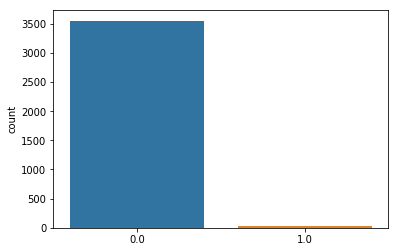

In [19]:
sns.countplot(Y[:, 15])

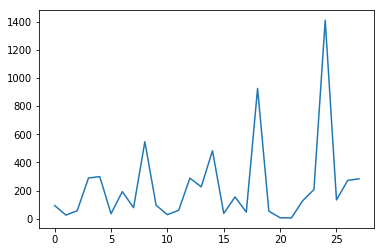

In [20]:
plt.plot(counts)

In [21]:
indexes = []
labels_new = []
counts_new = []

for i in range(len(labels)):
    if counts[i] > 50:
        labels_new.append(labels[i])
        counts_new.append(counts[i])
        indexes.append(i)
        
Y = Y[:, indexes]

In [22]:
print(len(labels_new))
print(labels_new)
print()
print(counts_new)

21
['искусство, развлечения, масс-медиа', 'юристы', 'туризм, гостиницы, рестораны', 'маркетинг, реклама, pr', 'бухгалтерия, управленческий учет, финансы предприятия', 'спортивные клубы, фитнес, салоны красоты', 'административный персонал', 'управление персоналом, тренинги', 'наука, образование', 'банки, инвестиции, лизинг', 'консультирование', 'информационные технологии, интернет, телеком', 'рабочий персонал', 'начало карьеры, студенты', 'высший менеджмент', 'автомобильный бизнес', 'производство', 'продажи', 'медицина, фармацевтика', 'строительство, недвижимость', 'транспорт, логистика']

[93.0, 56.0, 289.0, 299.0, 192.0, 78.0, 547.0, 95.0, 59.0, 288.0, 226.0, 483.0, 154.0, 926.0, 53.0, 127.0, 207.0, 1411.0, 133.0, 272.0, 283.0]


In [46]:
classes_weights = []
max_count = max(counts_new)
for i in range(len(counts_new)):
    weight = max_count / counts_new[i] 
    classes_weights.append(weight)

classes_weights = [classes_weights]  
print(classes_weights) 
print(len(classes_weights))

[[18.141025641025642, 7.075, 5.1454545454545455, 9.188311688311689, 2.7263969171483624, 4.879310344827586, 11.141732283464567, 4.477848101265823, 1.5149892933618843, 6.072961373390558, 5.0, 4.66996699669967, 14.894736842105264, 24.396551724137932, 1.0, 6.706161137440758, 10.559701492537313, 24.82456140350877, 2.5634057971014492, 22.822580645161292, 14.894736842105264]]
1


### Training

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2511, 300, 300)
(1077, 300, 300)
(2511, 21)
(1077, 21)


In [24]:
del X
del Y

In [ ]:
for_class = 4
num_pos = np.sum(Y_train[:, for_class])
num_neg = len(Y_train[:, for_class]) - num_pos
sample_weight = np.ones(Y_train[:, for_class].shape)
sample_weight[Y_train[:, i] == 1] = num_neg / num_pos * 100

print("Weight =",num_neg / num_pos)

In [ ]:
len(labels_new)

In [ ]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, padding= 'same',
                 activation="relu", input_shape=(max_len, 300)))
model.add(MaxPooling1D(pool_size=2))

#model.add(LSTM(100))
model.add(Bidirectional(layer=LSTM(50, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(50, activation="relu", kernel_regularizer=l2(0.1)))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid", kernel_regularizer=l2(0.1)))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

In [ ]:
%%time
model.fit(X_train, Y_train[:, for_class],
          batch_size=64, 
          epochs=5,
          #validation_split=0.15,
          verbose=1,
          sample_weight=sample_weight)


In [ ]:
y_predict = model.predict_classes(X_train)

print("\nTrain set result: ")
print(metrics.classification_report(Y_train[:, for_class], y_predict))
print("Confussion matrix: \n", metrics.confusion_matrix(Y_train[:, for_class], y_predict))

accuracy = metrics.f1_score(Y_train[:, for_class], y_predict)
print("\nF1 on train set: ", accuracy)

y_predict = model.predict_classes(X_test)

print("\nTrain set result: ")
print(metrics.classification_report(Y_test[:, for_class], y_predict))
print("Confussion matrix: \n", metrics.confusion_matrix(Y_test[:, for_class], y_predict))

accuracy = metrics.f1_score(Y_test[:, for_class], y_predict)
print("\nF1 on train set: ", accuracy)

In [ ]:
%%time
scores = model.evaluate(X_test, Y_test, batch_size=64)
print("Test accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:

classif_list = []
train_score_list, test_score_list = [], []

# Training
for i in range(len(labels)):
    y_train_for_label = Y_train[:,i]
    new_classifier = GaussianNB()
    new_classifier.fit(X_train, y_train_for_label)
    classif_list.append(new_classifier)

### Test

In [ ]:
# Test & display results
for i in range(len(birds_list)):
    classif = classif_list[i]
    train_score = float('{0:.3f}'.format(classif.score(X_train, y_train[:,i])))
    test_score = float('{0:.3f}'.format(classif.score(X_test, y_test[:,i])))
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    print('Detecting {} with {}% accuracy (training {}%)'.format(birds_list[i], 100*test_score, 100*train_score))

predict_train = np.zeros_like(y_train)
predict_test = np.zeros_like(y_test)
for i in range(len(birds_list)):
    classif = classif_list[i]
    predict_train[:,i] = classif.predict(X_train)
    predict_test[:,i] = classif.predict(X_test)
acc_train = 1 - np.sum(np.abs(predict_train - y_train))/(y_train.shape[0]*y_train.shape[1])
acc_test = 1 - np.sum(np.abs(predict_test - y_test))/(y_test.shape[0]*y_test.shape[1])
print('###')
print('Global accuracy: testing {}, training {}'.format(acc_test, acc_train))

well_labeled = 0
for i in range(len(y_train)):
    if np.sum(np.abs(y_train[i,:] - predict_train[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} training samples were well labeled'.format(well_labeled,len(y_train)))

well_labeled = 0
for i in range(len(y_test)):
    if np.sum(np.abs(y_test[i,:] - predict_test[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(y_test)))
